In [2]:
using Distributions, ForwardDiff, Plots, LinearAlgebra

# Poisson Linear Dynamical System

In [246]:
# Generate synthetic data
T = 50
x_real, y_real = zeros(T), zeros(T)
x_real[1] = randn()
y_real[1] = rand(Poisson(exp(x_real[1])))
for t=2:T
    x_real[t] = x_real[t-1] + randn() #variance 1
    y_real[t] = rand(Poisson(exp(x_real[t])))
end

In [247]:
y_real

50-element Array{Float64,1}:
  0.0
  2.0
  0.0
  0.0
  1.0
  0.0
  0.0
  0.0
  1.0
  4.0
  0.0
  0.0
  0.0
  ⋮  
  3.0
  0.0
  0.0
  1.0
  9.0
 35.0
  6.0
  9.0
 14.0
  4.0
  9.0
 18.0

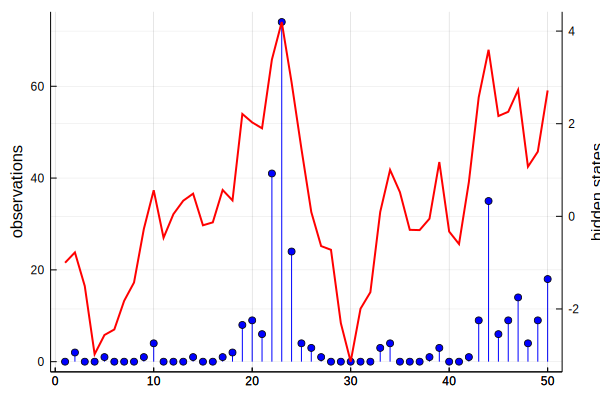

In [248]:
plt = plot([1,1],[0,y_real[1]], legend=false,color=:blue, ylabel="observations")
plot!((1,y_real[1]),seriestype = :scatter, color=:blue)
for t=2:T
    plot!([t,t],[0,y_real[t]], color=:blue)
    plot!((t,y_real[t]),seriestype = :scatter, color=:blue)
end
plt
plt = twinx()
plot!(plt, x_real, color=:red, lw=2, legend=false, ylabel="hidden states")

## Inference

In [249]:
struct Gaussian
    #source parameters
    m
    v
    #natural parameters
    lambda1
    lambda2
    Gaussian(m,v) = new(m,v,m/v,-0.5/v)
end

In [250]:
sample(p::Gaussian) = p.m + sqrt(p.v)*randn()

sample (generic function with 1 method)

In [251]:
p_1_0 = Gaussian(0,2) #prior on x1

Gaussian(0, 2, 0.0, -0.25)

In [252]:
logp(y,x) = logpdf(Poisson(exp(x)),y) #logevidence

logp (generic function with 1 method)

In [253]:
#emission noise is assumed 0.1
function transition(p::Gaussian)
    return Gaussian(p.m,p.v+0.1)
end

transition (generic function with 1 method)

In [254]:
function update(p0::Gaussian,q::Gaussian,y,N::Int,step_size=0.1)
    ss = step_size
    logp_x(x) = logp(y,x)
    q_s = q
    satisfied = 0
    count = 1
    l1,l2 = 0,0
    lambda1, lambda2 = p0.lambda1, p0.lambda2
    while satisfied == 0
        dmu1, dmu2 = 0,0
        for n=1:N
            # rejection sampling for stability
            x_s = sample(q_s) #sample from q
            while logp_x(x_s) == -Inf
                x_s = sample(q_s) #sample from q
            end
            # derivatives w.r.t. moments (easy since q is chosen Gaussian o.w. use Reparameterization trick or Reinforce)
            dm(x) = ForwardDiff.derivative(logp_x,x)
            dv(x) = 0.5*ForwardDiff.derivative(dm,x)
            dmu1 += dm(x_s) - 2*dv(x_s)*q_s.m
            dmu2 += dv(x_s)
        end
        dmu1, dmu2 = dmu1/N, dmu2/N
        #nonconjugate natural parameter approximation
        l1 = (1-step_size)*l1 + step_size*(dmu1)
        l2 = (1-step_size)*l2 + step_size*(dmu2)
        step_size = ss/(count+1)
        #conjugate update
        lambda1_new = l1 + p0.lambda1
        lambda2_new = l2 + p0.lambda2
        if abs(lambda1-lambda1_new)<0.01 && abs(lambda2-lambda2_new)<0.01
            satisfied = 1
        elseif count == 500
            satisfied = 1
        else
            count += 1
            #check if natural parameter is still in valid range
            if lambda2_new < 0
                lambda1, lambda2 = lambda1_new, lambda2_new
            else
                lambda1 = lambda1_new
            end
        end
        v = -0.5/lambda2
        m = lambda1*v
        #update q
        q_s = Gaussian(m,v)
    end
    return q_s
end

update (generic function with 2 methods)

In [255]:
update(p_1_0,p_1_0,2.0,3)

Gaussian(0.21089071339815207, 1.1376259133782234, 0.18537790930931247, -0.4395117886469648)

In [256]:
#filtering
m_list, v_list = zeros(T), zeros(T)
p_t_0 = p_1_0
for t=1:T
    #q = p_t_0
    q = Gaussian(0,1)
    p_t_t = update(p_t_0,q,y_real[t],3)
    @show p_t_t
    m_list[t], v_list[t] = p_t_t.m, p_t_t.v
    p_t_0 = transition(p_t_t)
    @show p_t_0
    @show y_real[t]
end

p_t_t = Gaussian(-0.4639090166466377, 1.1979389764783597, -0.3872559669194619, -0.4173835310625543)
p_t_0 = Gaussian(-0.4639090166466377, 1.2979389764783598, -0.3574197439584883, -0.38522612315459376)
y_real[t] = 0.0
p_t_t = Gaussian(-0.1256551438855468, 0.9988702917135323, -0.12579725809042647, -0.5005654929853454)
p_t_0 = Gaussian(-0.1256551438855468, 1.0988702917135322, -0.11434938666838053, -0.4550127560736226)
y_real[t] = 2.0
p_t_t = Gaussian(-0.3240262264960367, 0.8888362053465152, -0.36455111138245566, -0.5625333407802325)
p_t_0 = Gaussian(-0.3240262264960367, 0.9888362053465152, -0.3276844281631952, -0.5056449160099132)
y_real[t] = 0.0
p_t_t = Gaussian(-0.5451828723967013, 0.7602708799746817, -0.717090298677304, -0.6576603328758966)
p_t_0 = Gaussian(-0.5451828723967013, 0.8602708799746817, -0.6337339611132093, -0.5812122805025265)
y_real[t] = 0.0
p_t_t = Gaussian(-0.49326104433107604, 0.7788598542240054, -0.6333116820130914, -0.641964016104233)
p_t_0 = Gaussian(-0.4932610443310

p_t_t = Gaussian(2.2207633600939705, 0.12301651678107495, 18.052562519276403, -4.0644948587661585)
p_t_0 = Gaussian(2.2207633600939705, 0.22301651678107495, 9.957842549724655, -2.241986410768073)
y_real[t] = 9.0
p_t_t = Gaussian(2.600821953542047, 0.10101005945912676, 25.748147931686518, -4.950002036206331)
p_t_0 = Gaussian(2.600821953542047, 0.20101005945912676, 12.93876515702885, -2.4874377001100765)
y_real[t] = 18.0


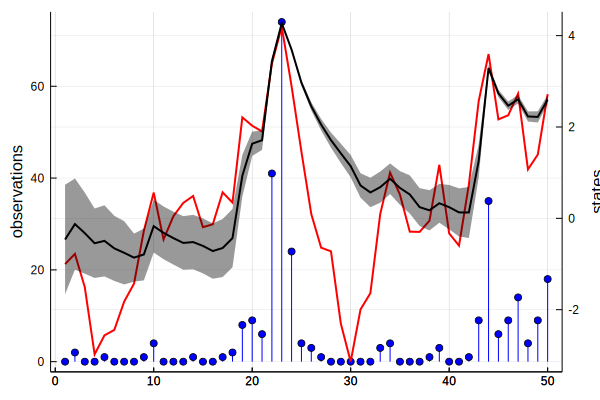

In [257]:
plt = plot([1,1],[0,y_real[1]], legend=false,color=:blue, ylabel="observations")
plot!((1,y_real[1]),seriestype = :scatter, color=:blue)
for t=2:T
    plot!([t,t],[0,y_real[t]], color=:blue)
    plot!((t,y_real[t]),seriestype = :scatter, color=:blue)
end
plt
plt = twinx()
plot!(plt, x_real, color=:red, lw=2, legend=false, ylabel="states")
plot!(plt,m_list, ribbon=v_list, fillalpha=0.4, color=:black,lw=2)